# MATH 70098 Ethics in DS and AI (Part 1)

**Autumn Term 2022/23**

**CID:** 01252821

---------

## Assessment Instructions

You should submit **two files** in total for this assessment. These files should be submitted via the Imperial College Coursera VLE by the **Deadline: Monday 05 December 2022 at 23:59 (UK).**

These files should be your completed version of this notebook and the completed notebook exported as a pdf file. These files should be named as follows:
    
- ethics_cw_YOURCID.ipynb
- ethics_cw_YOURCID.pdf

It is your responsibility to ensure each document is uploaded to the correct part of the learning space. 

All submitted materials should be clearly presented and be understandable as stand-alone documents. This coursework is expected to take approximately **7 hours** of individual effort and will be marked out of a total of **26 marks**.

This coursework counts for 75% of  your total mark for Ethics Part I. Ethics Part I has a 20% weighting and so this coursework counts for **15% of your total mark for the Ethics module**. 

**Plagiarism:** Your submission should be your own work. Note that software tools are used
for plagiarism detection.

--------

## Preprocessing - DO NOT EDIT

In [1]:
# uncomment and run if you do not already have the shap module installed
#!pip install shap

In [2]:
import pandas as pd
import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.optimize import minimize

In [3]:
df = pd.read_csv('./charity_data.csv',header = 0)

In [4]:
# format gender as a categorical variable
df = pd.get_dummies(df) 
df = df.drop('gender_Female', axis = 'columns')
df

,age,risk_score,uses_drugs,gender_Male
0,33,120,False,1
1,46,146,False,0
2,71,723,False,0
3,55,250,False,1
4,44,129,False,1
...,...,...,...,...
228,23,454,False,1
229,45,141,False,0
230,46,141,True,0
231,82,792,True,1


In [5]:
# Separate predictors and target variable
X = df.drop('uses_drugs', axis = 'columns')
y = df.uses_drugs

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)


------
# Question 1

## Question 1a [3 marks]

Aggregate the full data table so that age is grouped by decade (i.e. 16-19, 20-29, 30-39, ...) and risk score is dichotomised into "High" scores > 500 and "Low" scores < 500. State and explain whether drug use is 2-anonymised in this table.

Suppose instead that the age groupings are altered to be split at multiples of 15 years (16-29, 30-44, 45-59, ...) or multiples of 20 years (16-19, 20-39, 40-59, ...). For what value(s) of $k$ would the data then be $k$-anonymised and what does this demonstrate about using aggregation to improve $k$-anonymity?

## Solution 1a

In [6]:
AGE_GROUPINGS = {
    "decade": {(16, 19), (20, 29), (30, 39), (40, 49), (50, 59), (60, 69), (70, 79), (80, 86)},
    "15_years": {(16, 29), (30, 44), (45, 59), (60, 74), (75, 86)},
    "20_years": {(16, 19), (20, 39), (40, 59), (60, 79), (80, 86)}
}

df["risk_score"] = df["risk_score"].apply(lambda x: "High" if x > 500 else "Low")

def anonymise_df(df: pd.DataFrame, grouping: str) -> None:
    df_anonymised = df.copy()
    for lower_age, upper_age in AGE_GROUPINGS[grouping]:
        df_anonymised.loc[
            (df_anonymised["age"] >= lower_age) & (df_anonymised["age"] <= upper_age), grouping
        ] = f"{lower_age}-{upper_age}"
    df_anonymised.drop(columns=["age"], inplace=True)
    df_anonymised.rename(columns={grouping: "age"}, inplace=True)
    print(f"Anonymised with grouping by {grouping}")
    print(df_anonymised.groupby(by=["age", "risk_score", "gender_Male"]).count())

In [7]:
anonymise_df(df=df, grouping="decade")

Anonymised with grouping by decade
                              uses_drugs
age   risk_score gender_Male            
16-19 High       0                     7
                 1                     5
      Low        0                     1
20-29 High       0                     2
                 1                     2
      Low        0                    17
                 1                    18
30-39 Low        0                    20
                 1                    20
40-49 Low        0                    18
                 1                    25
50-59 Low        0                    18
                 1                    16
60-69 High       0                    11
                 1                    10
      Low        0                     2
                 1                     2
70-79 High       0                    14
                 1                    12
80-86 High       0                     4
                 1                     4


In [8]:
anonymise_df(df=df, grouping="15_years")

Anonymised with grouping by 15_years
                              uses_drugs
age   risk_score gender_Male            
16-29 High       0                     9
                 1                     7
      Low        0                    18
                 1                    18
30-44 Low        0                    25
                 1                    34
45-59 Low        0                    31
                 1                    27
60-74 High       0                    17
                 1                    19
      Low        0                     2
                 1                     2
75-86 High       0                    12
                 1                     7


In [9]:
anonymise_df(df=df, grouping="20_years")

Anonymised with grouping by 20_years
                              uses_drugs
age   risk_score gender_Male            
16-19 High       0                     7
                 1                     5
      Low        0                     1
20-39 High       0                     2
                 1                     2
      Low        0                    37
                 1                    38
40-59 Low        0                    36
                 1                    41
60-79 High       0                    25
                 1                    22
      Low        0                     2
                 1                     2
80-86 High       0                     4
                 1                     4


- In the decades grouping drug use is not 2-anonymised beacuse there is an age-risk_score-gender_Male combination which is unique, it is observed for only 1 individual (which is > 0 and < k = 2). The smallest equivalence class of size 1 is for the age range 16-19, risk_score = Low, and gender_Male 0.

- In the mutliples of 15 years grouping - the smallest equivalence class is of size 2, and it is observed both for males and females. Therefore, the data is at most 2-anonymous.

- In the multiples of 20 years grouping we have the situation from the decades grouping - with smallest equivalence class of size for the same age-risk_score-gender_Male combination. So, the data is at most 1-anonymous.

- We can say that in general using bigger groups for aggregation allows for an anonymisation with a bigger value of $k$, which means better anonymity. But as we can see from the decades grouping and the multiples of 20 years grouping, there might be cases where one group might worsen the anonymisation, no matter that for the majority of the bigger groups there would be improvement.

## Question 1b [2 marks]

In a few sentences, explain in this context how $k$-anonymity benefits data subjects and describe two potential limitations of this technique.

## Solution 1b

- In the current context k-anonymity could improve the chances a person won't be re-identified from the available data and thus information about using certain drugs wouldn't be revealed and associated with the individual. This would preserve the indiviual's privacy.

- Two potential limitaions of this technique: 
   - **homogeneity attack** - even if the data has been k-anonymised, in the case of equal values fot the sensitive variable (in our context uses_drugs) in a set of $k$ records, the attacker could reveal this value for the set of $k$ records
   - **background knowledge attack** - the attacker has information about quasi-identifier variable/s and by associating it with the sensitive variable (in our context uses_drugs) could narrow the possible values for the sensitive variable


## Question 1c [2 marks]

Suppose that a direct response survey design was used by the charity to collect this data. 

Complete the code provided to fit a logistic regression and a random forest to the training data and predict drug use status in the test data. Plot the ROC curves for the two classifiers. Can you make a clear recommendation of which classifier to use?


## Solution 1c

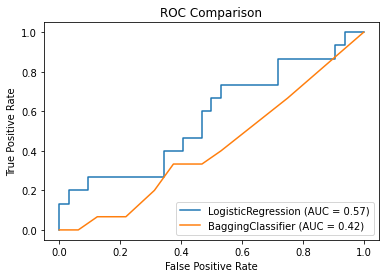

In [10]:
# Initialise a logistic regression and random forest classifier 
m0 = sklearn.linear_model.LogisticRegression()
m1 = sklearn.ensemble.BaggingClassifier(random_state=1234)

# Fit the two classifiers
m0.fit(X_train, y_train)
m1.fit(X_train, y_train)

# Plot the ROC curves
m0_roc = plot_roc_curve(m0, X_test, y_test)
plot_roc_curve(m1, X_test, y_test, ax=m0_roc.ax_)
plt.title("ROC Comparison")
plt.show()

The Logistic Regression classifier is performing better than the Random Forest one. 

In short:
- The lower left corner means we have 0% True Positive rate and 0% False Negative rate - we can associate it as a start point
- The upper left corner is the best scenario where we have 100% True Positive rate and 0% False Negative rate. So, this is our aim - to be as close as possible to it
- The upper right corner means we have 0% True Positive rate and 100% False Negative rate - we can associate it as an end point

Simply said: with want the area under the curve, with the mentioned start and end point, to be as close as possible to the aim (upper left corner), which would translate to - the area below this curve to be as big as possible (area <= 1). This is labeled as AUC on our plot and the bigger AUC indicates better performance of the classifier. 

Thus, due to the higher AUC the Logistic Regression classifier should be used, compared to the Random Forest.

## Question 1d [1 mark]

In a few sentences, explain the term error parity to the charity staff. Your explanation should be in plain language and given in the context of this situation, treating gender as the protected characteristic.

## Solution 1d

- Males and not-males should be misclassified with the same probability. Misclassification in our case occurs when an individiual is said to be using drugs when in reality the individual isn't using drugs or else the indiviual is using drugs but is said to not be using.

## Question 1e [4 marks]

Calculate the gender-specific error rates for each classifier. Use these to: 

- interpret the error rate differences for each classifier and suggest how these could be reduced;
- explain which, if any, classifier dominates the other in terms of predictive performance and error rate parity.

## Solution 1e

In [11]:
predictions = X_test.copy()
predictions["uses_drugs"] = y_test
predictions["m0_prediction"] = m0.predict(X_test)
predictions["m1_prediction"] = m1.predict(X_test)

In [12]:
N_m = len(predictions[predictions["gender_Male"] == True]) # number of males in the test set
N_w = len(predictions[predictions["gender_Male"] == False]) # number of females in the test set

In [13]:
# error rates for the Logistic Regression classifier - males
ERR_m0_m = len(
    predictions[(predictions["gender_Male"] == True) & (predictions["uses_drugs"] != predictions["m0_prediction"])]
    ) / N_m
ERR_m0_m

0.2608695652173913

In [14]:
# error rates for the Logistic Regression classifier - females
ERR_m0_w = len(
    predictions[(predictions["gender_Male"] == False) & (predictions["uses_drugs"] != predictions["m0_prediction"])]
    ) / N_w
ERR_m0_w

0.2916666666666667

In [15]:
# error rates for the Random Forest classifier - males
ERR_m1_m = len(
    predictions[(predictions["gender_Male"] == True) & (predictions["uses_drugs"] != predictions["m1_prediction"])]
    ) / N_m
ERR_m1_m

0.391304347826087

In [16]:
# error rates for the Random Forest classifier - females
ERR_m1_w = len(
    predictions[(predictions["gender_Male"] == False) & (predictions["uses_drugs"] != predictions["m1_prediction"])]
    ) / N_w
ERR_m1_w

0.5

- **Logistic regression**
   - ERR_m0_m = 0.2608695652173913
   - ERR_m0_w = 0.2916666666666667
   - the error rate for females is slighlty bigger than the one for males
- **Random forest**
   - ERR_m1_m = 0.391304347826087
   - ERR_m1_w = 0.5
   - the error rate for females is significantly bigger than the one for males

The error rates might be improved by using more suitable model parameters and by better feature engineering.

- **Conclusion**
   - the Logistic regression classifier has better AUC and performs better than the Random Forest 
   - the Logistc regression has lower error rates for females compared to males, the error rates are closer to error parity
   - Based on these two conclusions the Logistic regression seems to dominate over the Random Forest and be the better classifier for the case 

## Question  1f [3 marks]

Create a partial dependence plot for each predictor under both the random forest and logistic regression classifiers. In one or two sentences each: 

 - i. Explain the effect of the gender attribute in each model, phrasing your response as a counterfactual claim;
 - ii. Interpret and contrast the partial dependence plots for age and risk score under each model;

## Solution 1f

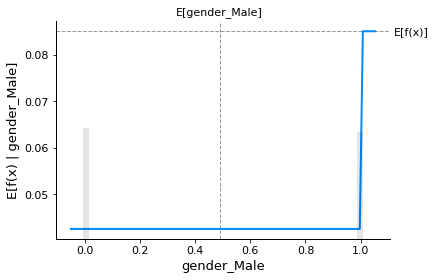

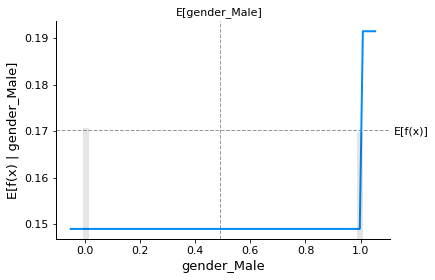

In [17]:
# gender_Male for the logistic regression model
fig, ax = shap.plots.partial_dependence(
    "gender_Male", 
    m0.predict, 
    X_test, 
    ice=False, 
    model_expected_value=True, 
    feature_expected_value=True,
    show=False
)
# gender_Male for the random foreast model
fig, ax = shap.plots.partial_dependence(
    "gender_Male", 
    m1.predict, 
    X_test, 
    ice=False, 
    model_expected_value=True, 
    feature_expected_value=True,
    show=False
)

- Effect of the gender attribute in each model 
   - Logistic Regression - If an individual wasn't male his chance of using drugs would have dropped slightly
   - Random Forest - If an individual wasn't male his chance of using drugs would have dropped moderately

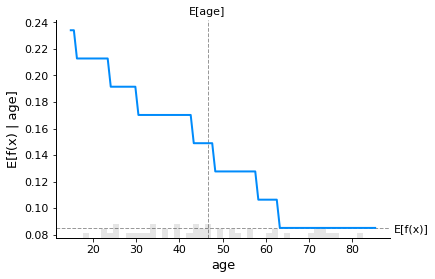

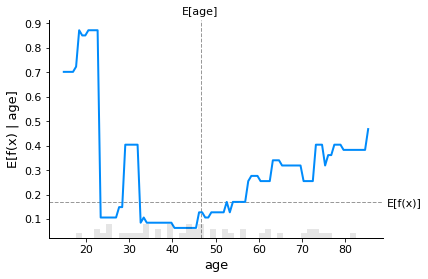

In [18]:
# age for the logistic regression model
fig, ax = shap.plots.partial_dependence(
    "age", 
    m0.predict, 
    X_test, 
    ice=False, 
    model_expected_value=True, 
    feature_expected_value=True,
    show=False
)
# age for the random foreast model
fig, ax = shap.plots.partial_dependence(
    "age", 
    m1.predict, 
    X_test, 
    ice=False, 
    model_expected_value=True, 
    feature_expected_value=True,
    show=False
)

- Age interpretation
   - Logistic Regression - The elder the individual the less likely the individual is to be using drugs.
   - Random Forest - The partial dependence plot seems somewhat "random", there is not a visible trend as a whole such as in the Logistic regression case. Given the worse performance of the Random Forest this is not strange.

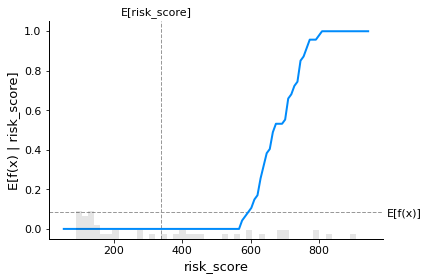

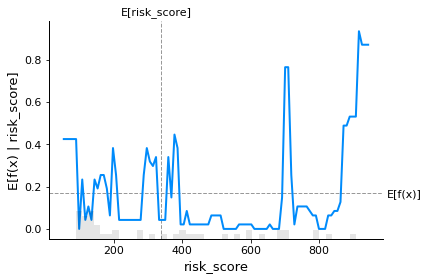

In [19]:
# risk_score for the logistic regression model
fig, ax = shap.plots.partial_dependence(
    "risk_score", 
    m0.predict, 
    X_test, 
    ice=False, 
    model_expected_value=True, 
    feature_expected_value=True,
    show=False
)
# risk_score for the random foreast model
fig, ax = shap.plots.partial_dependence(
    "risk_score", 
    m1.predict, 
    X_test, 
    ice=False, 
    model_expected_value=True, 
    feature_expected_value=True,
    show=False
)

- Risk score interpretation
   - Logistic Regression - The higher the risk score of the individual is the more likely the individual is to be using drugs.
   - Random Forest - The partial dependence plot seems somewhat "random", reminding of white noise, where there is not a visible trend and useful information can't be extracted as a whole. Given the worse performance of the Random Forest this is not strange as in the case with the age.

# Question 2

## Question 2a [3 marks]

Using the all of the survey responses and assuming a direct response survey design, calculate point estimates and 90% confidence intervals for the proportion of males ($p_m$) and the proportion of females ($p_f$) who are drug users.

In your working, for each respondent $i$ let:
- $D_i$ be an indicator that individual $i$ reports being a drug user 
- $G_i$ be an indicator that indivdual $i$ reports being male.

## Solution 2a 

Point estimates for the proportion of males ($p_m$) and the proportion of females ($p_f$):
- We will calculate $p_m$ as the number of male drug users divided by the total number of males. This would be equal to taking the sample mean of the male observations because we are working with indicators $D_i$ and $G_i$. 
- $p_m = \frac{\sum_{i=1}^{n} D_i}{\sum_{i=1}^{n} G_i} = \sum_{i=1}^{n} \frac{D_i}{n} = \frac{male-drug-users}{total-number-of-males}$

### Supporting code

In [20]:
males = len(df[df["gender_Male"] == True]) # total number of males in the dataframe
females = len(df[df["gender_Male"] == False]) # total number of females in the dataframe
drug_users_males = len(df[(df["uses_drugs"] == True) & (df['gender_Male'] == True)]) # total number of male drug users
drug_users_females = len(df[(df["uses_drugs"] == True) & (df['gender_Male'] == False)]) # total number of female drug users

In [21]:
p_m = drug_users_males / males # proportion of males using drugs
confidence_level = 0.90 # confidence level by problem statement
alpha = 1 - confidence_level
# for big number of observations we have:
margin_of_error = norm.ppf(1 - alpha / 2) * np.sqrt(p_m * (1 - p_m) / males)
# confidence interval bounds:
lower_bound = p_m - margin_of_error
upper_bound = p_m + margin_of_error
print(f"90% confidence interval for the proportion of males who use drugs: ({lower_bound}, {upper_bound})")

90% confidence interval for the proportion of males who use drugs: (0.26974903141525386, 0.4140116523454299)


In [22]:
p_f = drug_users_females / females
confidence_level = 0.90
alpha = 1 - confidence_level

margin_of_error = norm.ppf(1 - alpha / 2) * np.sqrt(p_f * (1 - p_f) / females)
lower_bound = p_f - margin_of_error
upper_bound = p_f + margin_of_error
print(f"90% confidence interval for the proportion of females who use drugs: ({lower_bound}, {upper_bound})")

90% confidence interval for the proportion of females who use drugs: (0.247786058600385, 0.3901449758823737)


## Question 2b [8 marks]

Suppose instead that a randomised response survey design was used to collect this data. In this survey design, each respondent replies honestly with probability $\tau$. With probability $1-\tau$, each respondent will negate _both_ their drug use and gender responses.

Let $g$ denote $\Pr(G_i  = 1)$, the population proportion of males and let Y_i denote the response of participant $i$ for $i = 1,\ldots,n$. To simplify notation abbreviate responses as follows: $a$ = {Male, Drug User}, $b$ = {Male, Not Drug User}, $c$ = {Female, Drug User} and $d$ = {Female, Not Drug User}.


- (i) Draw a probability tree for this randomised response design. [2 marks]

- (ii) Hence derive the log-likelihood function for the parameters $\theta = (g, p_m, p_f)$. [3 marks]

- (iii) Suppose that participants answered directly with probability $\tau = 0.8$. By finding the maximum likelhiood estimate $\overset{\sim}{\theta}$, quantify the bias that would be induced in each of $p_m$ and $p_f$ by incorrectly assuming a direct-response survey design. [3 marks]


## Solution 2b (i)

**Labeling:**
- $G$ = {the individual is a male} - by problem statement this is with probability $g$
- $G^C$ - the complement of G
- $R$ = {the response is honest} - by problem statement this is with probability $\tau$
- $R^C$ - the complement of R, here the individual negates both their gender and drug use
- $D$ = {the individual uses drugs} - based on the gender taken from 2a this is with probability $p_m$ for males and $p_f$ for females
- $D^C$ - the complement of D

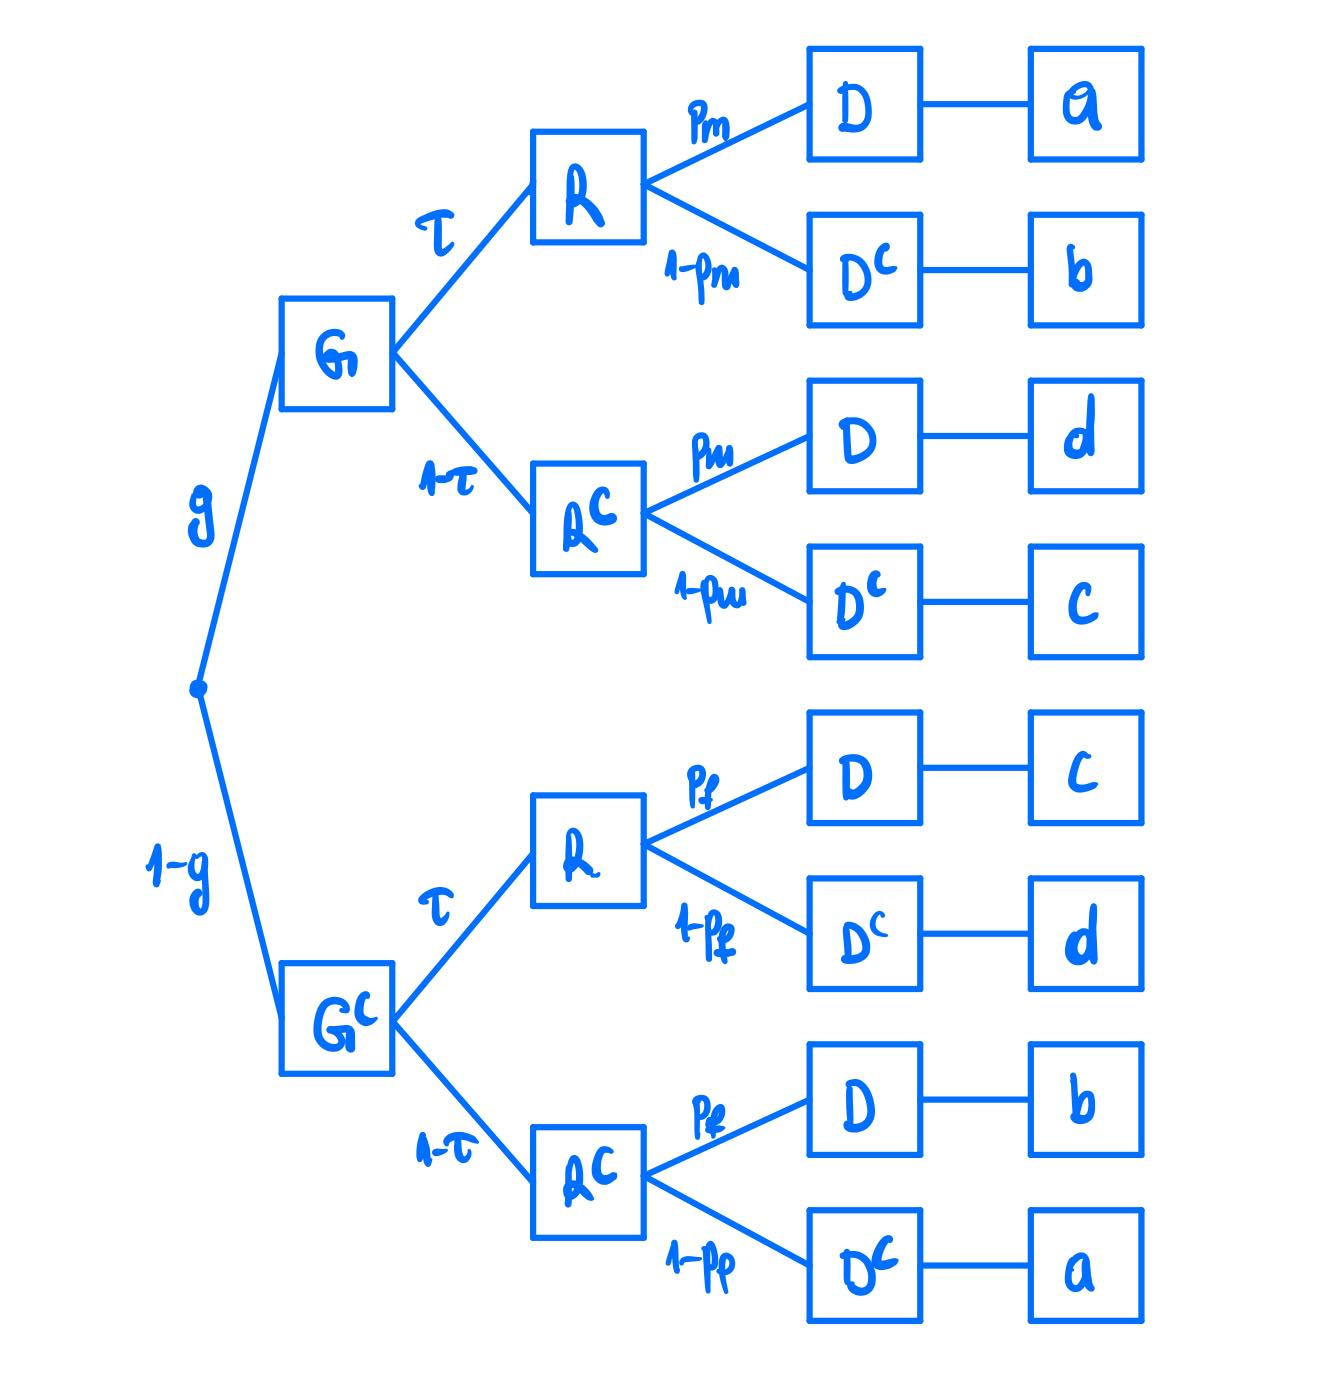

In [23]:
from IPython.display import Image
Image(filename='probability_tree.jpg')

## Solution 2b (ii) 

Having drawn the probability tree we can state that we have the probability mass function of our distribution.
The state space is S = {a, b, c, d} and we have the probabilites for each of these states:

- $Pr(X=a) = Pr((G \cap R \cap D) \cup (G^C \cap R^C \cap D^C)) = Pr(G)Pr(R)Pr(D) + Pr(G^C)Pr(R^C)Pr(D^C) = g \tau p_m + (1-g)(1-\tau)(1-p_f)$
- $Pr(X=b) = g\tau(1-p_m) + (1-g)(1-\tau)p_f$
- $Pr(X=c) = g(1-\tau)(1-p_m) + (1-g)\tau p_f$
- $Pr(X=d) = g(1-\tau)p_m + (1-g)\tau (1-p_f)$

For the likelihood function we have:
$L(\theta) =  Pr(X=a)^{n_0} Pr(X=b)^{n_1} Pr(X=c)^{n_2} Pr(X=d)^{n_3}$, where 
- $n_0$ number of samples that take the value X=a
- $n_1$ number of samples that take the value X=b
- $n_2$ number of samples that take the value X=c
- $n_3$ number of samples that take the value X=d

Then for the log-likelihood function we have:

$l(\theta) = log L(\theta) = n_0 log(g \tau p_m + (1-g)(1-\tau)(1-p_f)) + n_1 log(g\tau(1-p_m) + (1-g)(1-\tau)p_f) + n_2 log(g(1-\tau)(1-p_m) + (1-g)\tau p_f) + n_3 log(g(1-\tau)p_m + (1-g)\tau (1-p_f))$

## Solution 2b (iii)

In [24]:
# known values from df
N0 = len(df[(df["gender_Male"] == True) & (df["uses_drugs"] == True)])
N1 = len(df[(df["gender_Male"] == True) & (df["uses_drugs"] == False)])
N2 = len(df[(df["gender_Male"] == False) & (df["uses_drugs"] == True)])
N3 = len(df[(df["gender_Male"] == False) & (df["uses_drugs"] == False)])
# known by problem statement
TAU = 0.8

def f(params) -> float:
    """The log-likelihood function taken with the opposite sign because
    we have to maximize the log-likelihood function by using the 
    minimize function from the scipy library.
    """
    g, pm, pf = params
    print(params)
    a_term = N0 * np.log(g * TAU * pm + (1 - g) * (1 - TAU) * (1 - pf))
    b_term = N1 * np.log(g * TAU * (1 - pm) + (1 - g) * (1 - TAU) * pf)
    c_term = N2 * np.log(g * (1 - TAU) * (1 - pm) + (1 - g) * TAU * pf)
    d_term = N3 * np.log(g * (1 - TAU) * pm + (1 - g) * TAU * (1 - pf))

    return -(a_term + b_term + c_term + d_term)

initial_guess = [0.9, 0.9, 0.9]
bounds = ((0.01, 1.0), (0.01, 1.0), (0.01, 1.0))
result = minimize(f, initial_guess, bounds=bounds)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

[0.9 0.9 0.9]
[0.90000001 0.9        0.9       ]
[0.9        0.90000001 0.9       ]
[0.9        0.9        0.90000001]
[0.01 0.01 1.  ]
[0.01000001 0.01       1.        ]
[0.01       0.01000001 1.        ]
[0.01       0.01       0.99999999]
[0.50472024 0.50472024 0.94441346]
[0.50472025 0.50472024 0.94441346]
[0.50472024 0.50472025 0.94441346]
[0.50472024 0.50472024 0.94441347]
[0.56937417 0.50410039 0.76474437]
[0.56937418 0.50410039 0.76474437]
[0.56937417 0.5041004  0.76474437]
[0.56937417 0.50410039 0.76474438]
[0.5505327  0.47209277 0.63210699]
[0.55053271 0.47209277 0.63210699]
[0.5505327  0.47209278 0.63210699]
[0.5505327  0.47209277 0.632107  ]
[0.41039026 0.34375812 0.25683974]
[0.41039027 0.34375812 0.25683974]
[0.41039026 0.34375813 0.25683974]
[0.41039026 0.34375812 0.25683975]
[0.51998638 0.26170655 0.24893761]
[0.51998639 0.26170655 0.24893761]
[0.51998638 0.26170656 0.24893761]
[0.51998638 0.26170655 0.24893762]
[0.51054211 0.23750486 0.20563144]
[0.51054212 0.23750486 0

In [25]:
# We get the values obtained from the MLE:
g_mle, pm_mle, pf_mle = fitted_params
# From 2a we have p_m and p_f
# For the difference we get:
print(f"Induced bias for p_m: {p_m - pm_mle}")
print(f"Induced bias for p_f: {p_f - pf_mle}")

Induced bias for p_m: 0.11176731004898577
Induced bias for p_f: 0.11435477706986294
